\# Welcome to CS 5242 **Homework 3**

ASSIGNMENT DEADLINE ⏰ : **23:59 22 Mar 2024**

In this assignment, we will delve into **FlashAttention**, a widely-used algorithm renowned for its ability to replace standard attention mechanisms with the advantages of higher speed and lower memory consumption. For an in-depth understanding, you can refer to the original paper available at https://arxiv.org/abs/2205.14135.

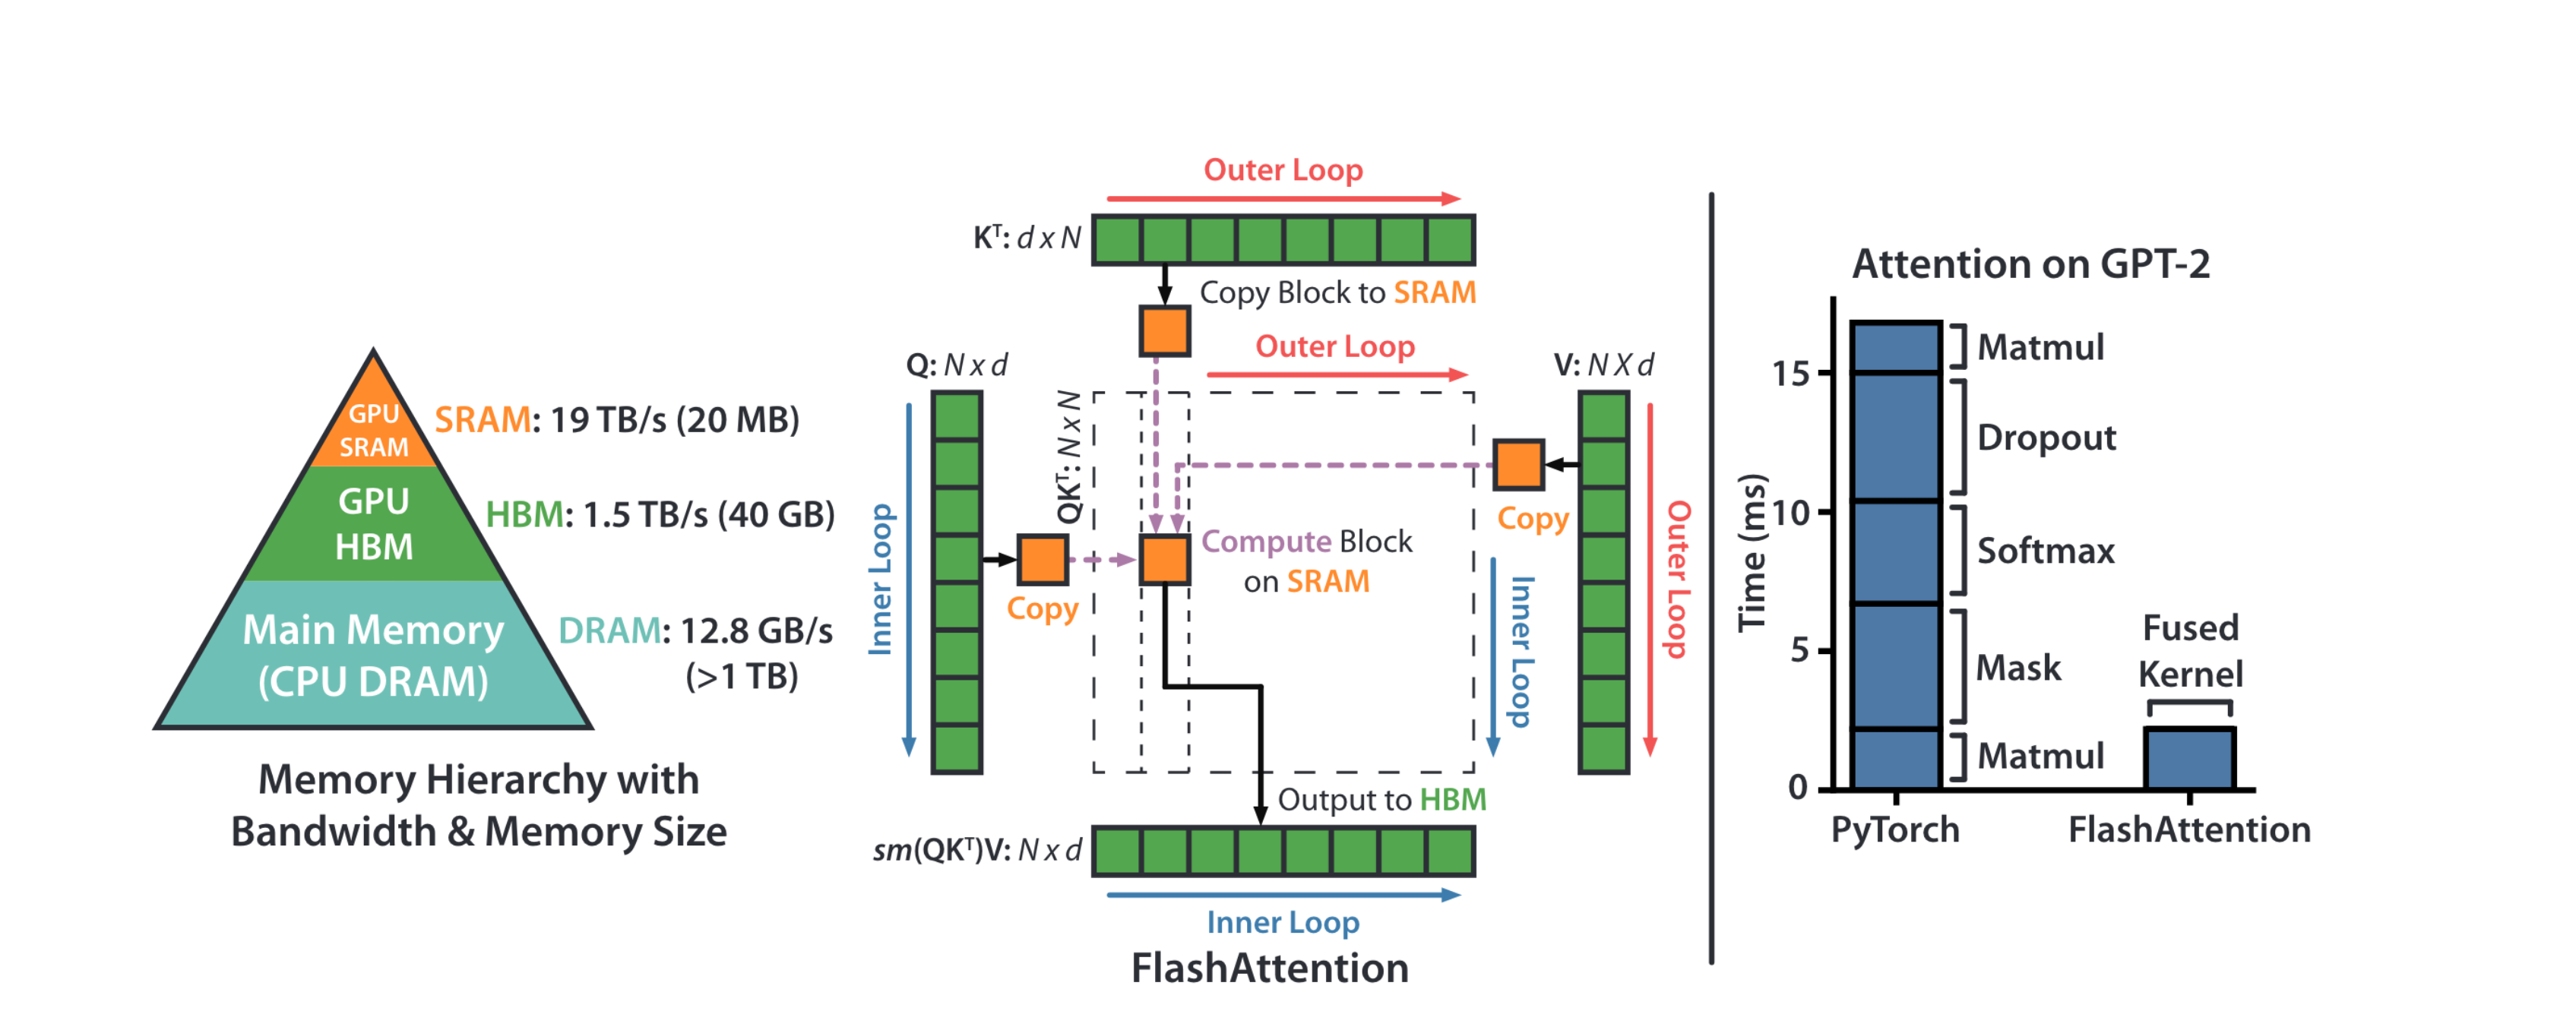

Transformers have grown larger and deeper, but equipping them with longer context remains difficult, since the self-attention module at their heart has time and memory complexity **quadratic** in sequence length. On modern GPUs, compute speed has out-paced memory speed, and most operations in Transformers are bottlenecked by memory accesses. IO-aware algorithms have been critical for similar memory-bound operations, when reading and writing data can account for a large portion of the runtime. However, common Python interfaces to deep learning such as PyTorch and Tensorflow **do not allow fine-grained control of memory access**.

**Our main goal** is to avoid reading and writing the attention matrix to and from HBM. This requires (i) computing the softmax reduction **without** access to the whole input (ii) not storing the large intermediate attention matrix for the backward pass.

Facing the above challenges, the author (i) restructure the attention computation to split the input into blocks and make several passes over input blocks, thus incrementally performing the softmax reduction (also known as tiling). (ii) store the softmax normalization factor from the forward pass to quickly recompute attention on-chip in the backward pass, which is faster than the standard approach of reading the intermediate attention matrix from HBM.

In this assignment, you are tasked with implementing the algorithm described in FlashAttention, utilizing **PyTorch**. While direct management of memory access is beyond the scope of PyTorch's capabilities, this exercise will provide you with a clearer understanding of the mechanics and reasons behind FlashAttention's effectiveness on GPUs. Gaining an in-depth understanding of FlashAttention is immensely beneficial, especially if you plan to pursue a career in Deep Learning, as it is a tool you will frequently encounter and use.

In the first part, you will learn why FlashAttention can break softmax function's dependency on the whole sequence. In the second part, you will implement the tiling algorithm of PyTorch and check if its output is the same as a standard attention module.

### Part one  Online softmax

Here is the algorithm of a standard attention function.

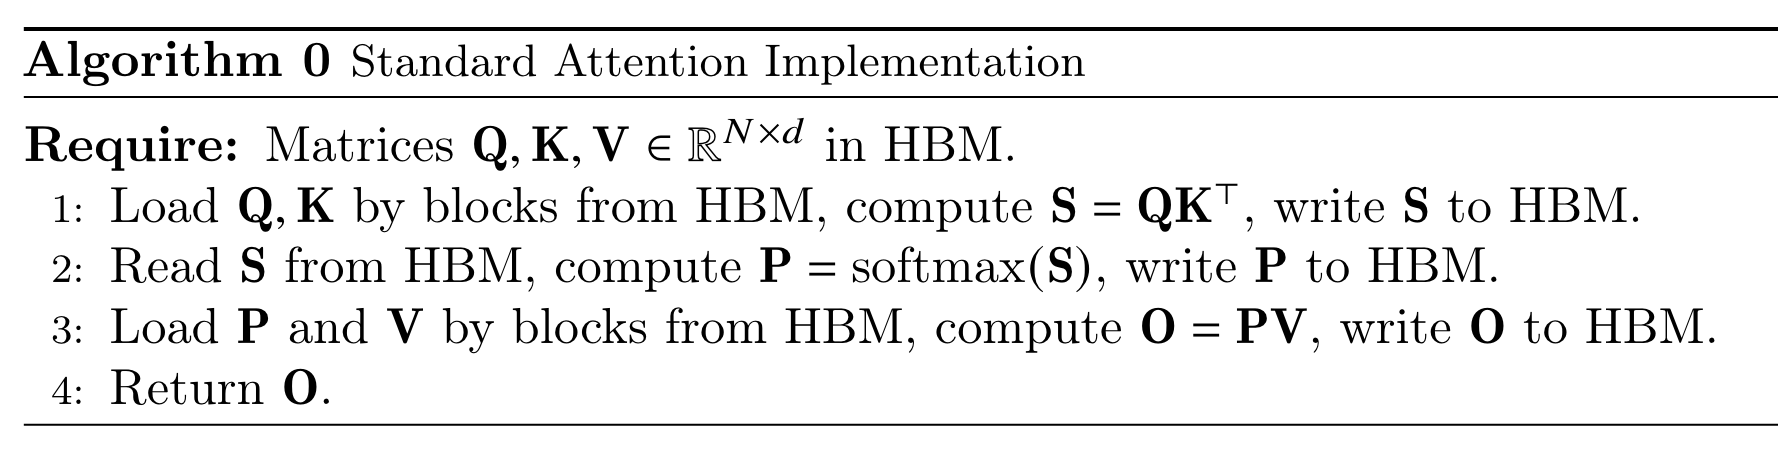

From our previous lecture, we discussed that a standard attention function involves the multiplication of Q, with dimensions (batch_size, sequence_length, hidden_dimension), and the transposed K, also with dimensions (batch_size, sequence_length, hidden_dimension). This process results in an intermediate activation represented as S, with dimensions (batch_size, **sequence_length, sequence_length**). When dealing with long sequence lengths, the size of S becomes considerably large, necessitating significant memory space for storage. This extensive memory requirement can pose challenges for computations on GPUs with limited memory, making the process less efficient.

Indeed, it's a logical progression to consider dividing Q, K, and V into smaller segments and performing the multiplication process iteratively in order to reduce memory consumption. This approach aligns with basic principles of Linear Algebra, which indicate that matrix multiplication can be segmented as follows:      (for further explanation please check https://en.wikipedia.org/wiki/Block_matrix)

Q (bs, sq_len, hid_dim) = (Q<sub>1</sub>, Q<sub>2</sub>, ..., Q<sub>n</sub>). Q<sub>i</sub> is of (bs, seq_len/n, hid_dim) each.

Similarly, K<sup>T</sup>(bs, hid_dim, sq_len) = (K<sub>1</sub>, K<sub>2</sub>, ..., K<sub>n</sub>). K<sub>i</sub> is of (bs, hid_dim, seq_len/n) each.

Thus, S = QK<sup>T</sup> =

(S<sub>11</sub>, S<sub>12</sub>, ... , S<sub>1n</sub>

 S<sub>21</sub>, S<sub>22</sub>, ... , S<sub>2n</sub>

... ... ... ...

 S<sub>n1</sub>, S<sub>n2</sub>, ... , S<sub>nn</sub>), where S<sub>ij</sub> = Q<sub>i</sub>K<sub>j</sub><sup>T</sup>.


However, there is one thing that's in our way: the softmax function. We know that the original softmax function needs to see the whole sequence before it gets the denominator, e<sup>x<sub>1</sub></sup> + e<sup>x<sub>2</sub></sup> + ... + e<sup>x<sub>n</sub></sup>, where n equals to seq_len. So we need to decompose the original softmax and update it step by step online. The formula of softmax is:


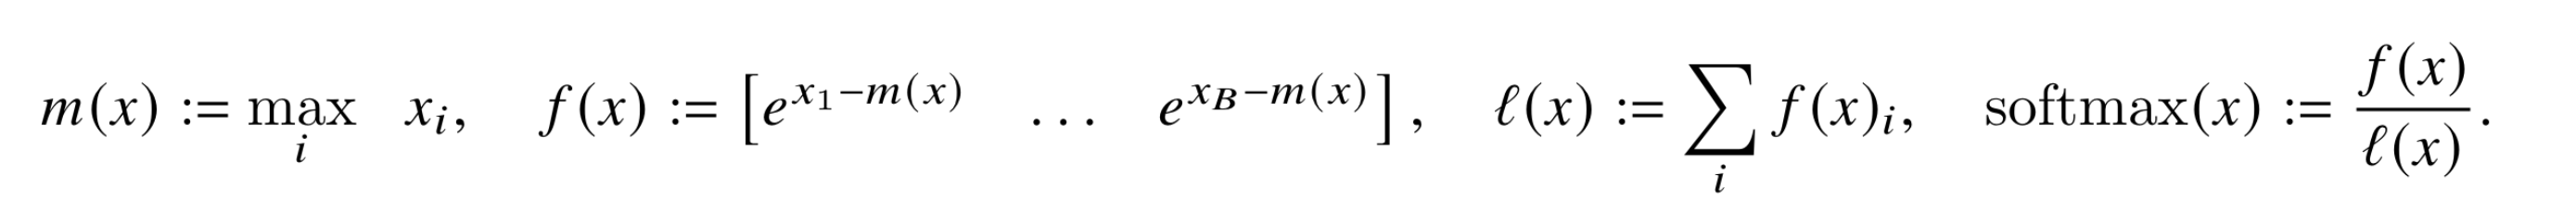

And we can decompose it by:

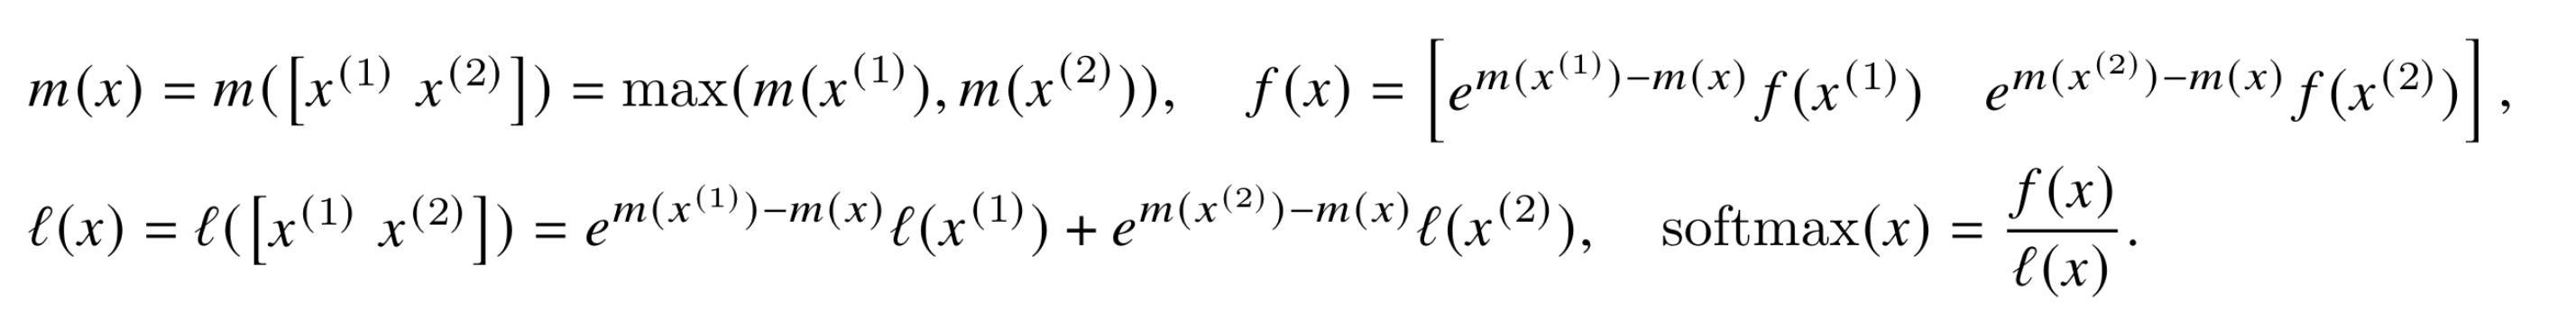

By storing two exltra variable m and l, we can update the local softmax result step and step before getting the final output. Now you can try to implement this algorithm.

In [ ]:
import torch
import torch.nn

x1 = torch.randn(16, 1024)
x2 = torch.randn(16, 1024)
torch.manual_seed(42)

def calculate_local_fx(x: torch.Tensor):

    # In this function, you should implement the algorithm of f(x) and return fx, l, and m together.
    # Suppose that we are doing softmax on the last dimension.
    # Note that you are not allowed to use torch.nn.Softmax in this function.
    ####### Your code starts here (1 point)



    ####### Your code ends here
    return fx, l, m

def decomposed_softmax(fx1, l1, m1, fx2, l2, m2) -> torch.Tensor:
    ####### Your code starts here (2 points)





    ####### Your code ends here
    return softmax_result

standard_softmax = torch.nn.Softmax(dim=-1)
standard_softmax_result = standard_softmax(torch.cat((x1, x2), dim=-1))
fx1, l1, m1 = calculate_local_fx(x1)
fx2, l2, m2 = calculate_local_fx(x2)
decompsed_softmax_result = decomposed_softmax(fx1, l1, m1, fx2, l2, m2)
print(torch.allclose(standard_softmax_result, decompsed_softmax_result, atol=1e-3))



###Part Two Flash Attention Implementation
Now that we have solved the problem of combining softmax, we can now start to implement the algorithm of FlashAttention!
Here is the algorithm of the forward propagation given in the paper:

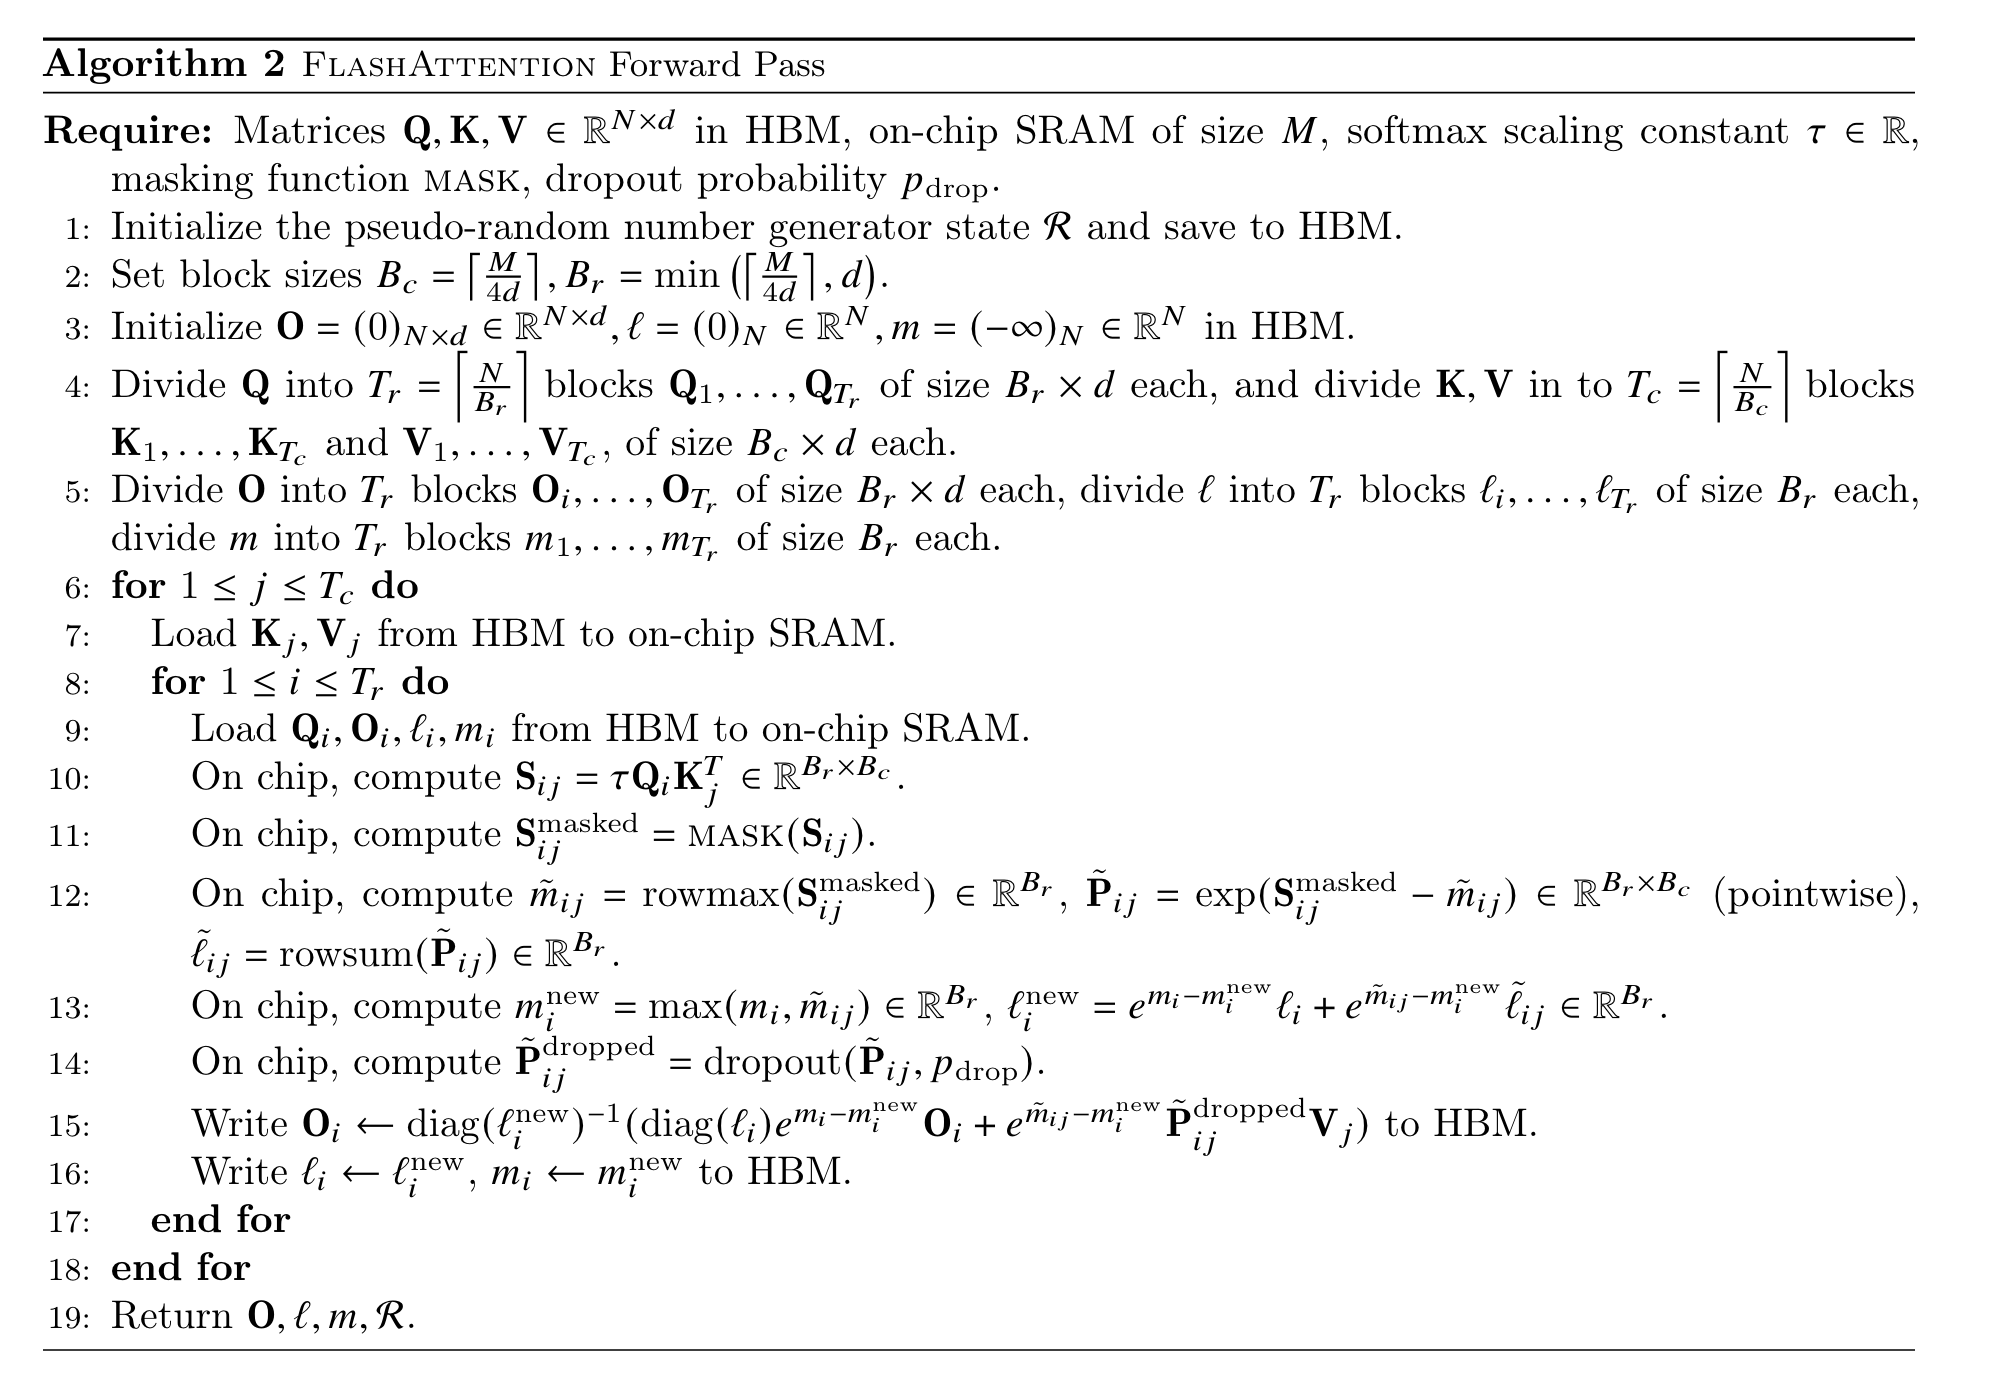

When implementing this algorithm with PyTorch, you do not need to pay attention to the "On chip" notes or "Write" operations. You only need to compute the O<sub>i</sub> step by step and cat the Os to get the final result. Also, you can **skip the dropout step and the mask operation** in this part.

First, we have a standard attention implementation with multiple head here:

In [ ]:
import torch.nn as nn
import math

class StdAttentionCore(nn.Module):
    def __init__(self, attention_head_size: int) -> None:
        super().__init__()
        self.softmax_scaling_constant = 1 / math.sqrt(attention_head_size)
        self.softmax = nn.Softmax(dim=-1)
        self.where_const = -1e4

    def forward(self, q, k, v):
        # q: (bs, seq_len_q, hidden_dim)
        x = torch.matmul(q, k.transpose(-1, -2))
        b, sq, sk = x.size()
        x = x * self.softmax_scaling_constant
        x = self.softmax(x)
        x = torch.matmul(x, v)
        return x

We will use this implementation as a standard answer to our FlashAttention implementation. Now we can start with the decomposed attention core:

In [ ]:
class FlashAttentionCore(nn.Module):
    def __init__(self, attention_head_size: int, block_size: int) -> None:
        super().__init__()
        self.softmax_scaling_constant = 1 / math.sqrt(attention_head_size)
        self.where_const = -1e4
        self.block_size = block_size

    def forward(self, q, k, v):
        # q: (bs, seq_len_q, head_size)
        num_blocks = q.shape[1] // self.block_size
        q_list, k_list, v_list = [torch.chunk(tensor, num_blocks, dim=1) for tensor in [q, k, v]]

        # initialize O, m, and l blocks to store the intermediate results
        O = [torch.zeros_like(q_list[0]) for _ in range(num_blocks)]
        ####### Your code starts here (1 point)



        ####### Your code ends here

        for j in range(num_blocks):
            for i in range(num_blocks):
                qi = q_list[i]
                kj = k_list[j]
                vj = v_list[j]
                ####### Your code starts here (6 points)







                ####### Your code ends here
                O[i] = new_O
                l[i] = new_l
                m[i] = new_m
        O = torch.cat(O, dim=1)
        return O

Now we can test the correctness!

In [ ]:
torch.manual_seed(42)
q, k, v = [torch.randn(8,512,768) for _ in range(3)]
std_attn = StdAttentionCore(q.shape[-1])
flash_attn = FlashAttentionCore(q.shape[-1], 8)

std_out = std_attn(q, k, v)
flash_out = flash_attn(q, k, v)
print(torch.allclose(std_out, flash_out, atol=1e-3))